In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

df = pd.read_csv('df_empilhado_final.csv')
df = df.drop(columns=["Unnamed: 0"])

colunas_numericas = df.columns.difference(['Nome', 'Data'])  # Exclui 'Nome' e 'Data'

# Passo 2: Remova vírgulas e converta colunas numéricas para float
for col in colunas_numericas:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)
df

,Nome,Data,EBITDA,LG,DE,GMV,ROA,ROE,FCLA,FCLF
0,3tentos,2021-07-01,119436.0,1.6,43.7,4694121.0,2.2,4.7,186785.0,-1108032.0
1,3tentos,2021-10-01,83550.0,1.7,35.8,4807768.0,3.8,7.5,-119487.0,-94868.0
2,3tentos,2022-01-01,54560.0,1.5,55.7,4887747.0,1.1,2.5,-320523.0,-409704.0
3,3tentos,2022-07-01,108988.0,1.4,44.5,5458398.0,2.9,6.5,596343.0,28224.0
4,3tentos,2022-10-01,249174.0,1.4,38.9,4632208.0,3.7,7.9,-249977.0,69746.0
...,...,...,...,...,...,...,...,...,...,...
9056,Zamp S.A.,2023-07-01,78485.0,0.4,86.6,1635318.0,-1.0,-2.9,5425.0,93351.0
9057,Zamp S.A.,2023-10-01,157194.0,0.4,80.1,1520606.0,1.4,4.3,93978.0,441774.0
9058,Zamp S.A.,2024-01-01,38715.0,0.5,136.7,921349.0,-2.0,-6.9,-59692.0,-621912.0
9059,Zamp S.A.,2024-04-01,101653.0,0.5,125.5,1016474.0,-0.6,-2.2,10855.0,172447.0


,Nome,Data,EBITDA,LG,DE,GMV,ROA,ROE,FCLA,FCLF
0,3tentos,2021-07-01,119436.0,1.6,43.7,4694121.0,2.2,4.7,186785.0,-1108032.0
1,3tentos,2021-10-01,83550.0,1.7,35.8,4807768.0,3.8,7.5,-119487.0,-94868.0
2,3tentos,2022-01-01,54560.0,1.5,55.7,4887747.0,1.1,2.5,-320523.0,-409704.0
3,3tentos,2022-07-01,108988.0,1.4,44.5,5458398.0,2.9,6.5,596343.0,28224.0
4,3tentos,2022-10-01,249174.0,1.4,38.9,4632208.0,3.7,7.9,-249977.0,69746.0
...,...,...,...,...,...,...,...,...,...,...
9056,Zamp S.A.,2023-07-01,78485.0,0.4,86.6,1635318.0,-1.0,-2.9,5425.0,93351.0
9057,Zamp S.A.,2023-10-01,157194.0,0.4,80.1,1520606.0,1.4,4.3,93978.0,441774.0
9058,Zamp S.A.,2024-01-01,38715.0,0.5,136.7,921349.0,-2.0,-6.9,-59692.0,-621912.0
9059,Zamp S.A.,2024-04-01,101653.0,0.5,125.5,1016474.0,-0.6,-2.2,10855.0,172447.0


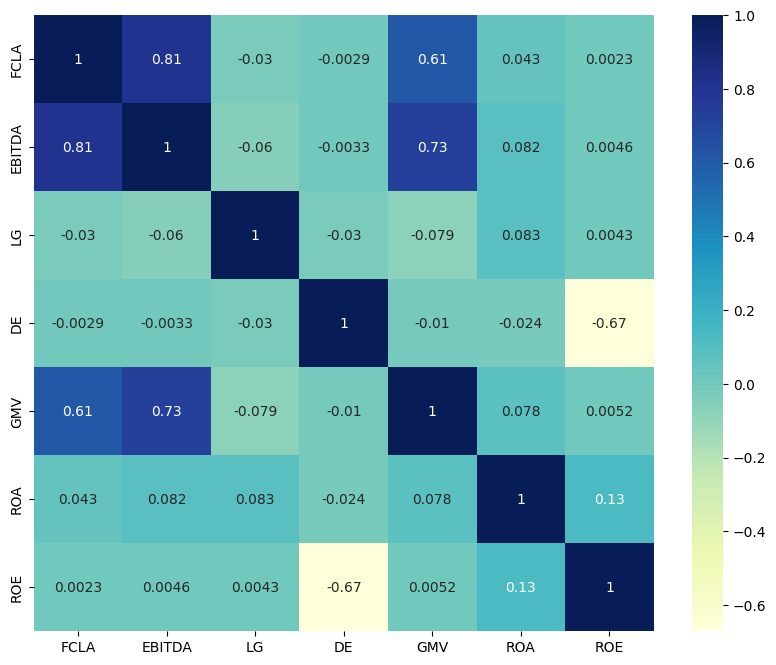

In [2]:
import seaborn as sns

features = ['FCLA', 'EBITDA', 'LG', 'DE', 'GMV', 'ROA', 'ROE']

plt.figure(figsize=(10, 8))
sns.heatmap(df[features].corr(), annot=True, cmap='YlGnBu')

df

In [3]:
from sklearn.preprocessing import MinMaxScaler 

def remover_outliers_std_por_empresa(df, empresa_col, cols, z=1.96):
    df_limpo = []

    for empresa, grupo in df.groupby(empresa_col):
        grupo_limpo = grupo.copy()
        for col in cols:
            media = grupo[col].mean()
            std = grupo[col].std()
            limite_inferior = media - z * std
            limite_superior = media + z * std
            grupo_limpo = grupo_limpo[(grupo_limpo[col] >= limite_inferior) & (grupo_limpo[col] <= limite_superior)]
        df_limpo.append(grupo_limpo)

    return pd.concat(df_limpo).reset_index(drop=True)

features = ['FCLA', 'FCLF', 'EBITDA', 'LG', 'DE', 'GMV', 'ROA', 'ROE']

df = remover_outliers_std_por_empresa(df, empresa_col='Nome', cols=features, z=1.96)

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df

,Nome,Data,EBITDA,LG,DE,GMV,ROA,ROE,FCLA,FCLF
0,3tentos,2022-01-01,0.231365,0.069444,0.004858,0.009618,0.390887,0.953660,0.135735,0.208538
1,3tentos,2022-07-01,0.231871,0.064815,0.003881,0.010742,0.434053,0.955771,0.148971,0.212809
2,3tentos,2022-10-01,0.233174,0.064815,0.003393,0.009115,0.453237,0.956510,0.136753,0.213214
3,3tentos,2023-01-01,0.231996,0.060185,0.003898,0.011975,0.402878,0.954241,0.141362,0.212032
4,3tentos,2023-04-01,0.231355,0.060185,0.003977,0.012601,0.393285,0.953713,0.135522,0.211325
...,...,...,...,...,...,...,...,...,...,...
6900,Zamp S.A.,2023-01-01,0.231427,0.018519,0.006707,0.002435,0.330935,0.950282,0.139260,0.212130
6901,Zamp S.A.,2023-04-01,0.231534,0.018519,0.007422,0.002383,0.326139,0.949913,0.139752,0.211907
6902,Zamp S.A.,2023-07-01,0.231587,0.018519,0.007553,0.003213,0.340528,0.950810,0.140440,0.213444
6903,Zamp S.A.,2023-10-01,0.232319,0.018519,0.006986,0.002987,0.398082,0.954610,0.141718,0.216842


In [4]:
df["g_FCLA_scaled"] = df.groupby("Nome")["FCLA"].pct_change()

df['g_FCLA_scaled'] = df['g_FCLA_scaled'].fillna(method='bfill')  

df_ = df[np.isfinite(df["g_FCLA_scaled"])]

if df['g_FCLA_scaled'].isnull().all():
    print("A coluna 'g' contém apenas valores ausentes.")

if df is None or df.empty:
    print("df_long não contém dados.")

df = df.dropna(subset=["g_FCLA_scaled"])
if len(df) == 0:
    print("Não há dados válidos para 'g' após o dropna.")
df

df['g_FCLA_scaled'] = df['g_FCLA_scaled'].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['g_FCLA_scaled'])

var = ['g_FCLA_scaled']

df = df.sort_values(['Nome', 'Data'])
df['lag1'] = df.groupby('Nome')[var].shift(1)
df['ma3'] = df.groupby('Nome')[var].transform(lambda x: x.shift(1).rolling(3).mean())

df['lag1'] = df['lag1'].fillna(method='bfill')  # backward fill

df['ma3'] = df['ma3'].fillna(method='bfill')  # backward fill
df

C:\Users\carlo\AppData\Local\Temp\ipykernel_23072\364049556.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['g_FCLA_scaled'] = df['g_FCLA_scaled'].fillna(method='bfill')
C:\Users\carlo\AppData\Local\Temp\ipykernel_23072\364049556.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['lag1'] = df['lag1'].fillna(method='bfill')  # backward fill
C:\Users\carlo\AppData\Local\Temp\ipykernel_23072\364049556.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma3'] = df['ma3'].fillna(method='bfill')  # backward fill


,Nome,Data,EBITDA,LG,DE,GMV,ROA,ROE,FCLA,FCLF,g_FCLA_scaled,lag1,ma3
0,3tentos,2022-01-01,0.231365,0.069444,0.004858,0.009618,0.390887,0.953660,0.135735,0.208538,0.097513,0.097513,0.037671
1,3tentos,2022-07-01,0.231871,0.064815,0.003881,0.010742,0.434053,0.955771,0.148971,0.212809,0.097513,0.097513,0.037671
2,3tentos,2022-10-01,0.233174,0.064815,0.003393,0.009115,0.453237,0.956510,0.136753,0.213214,-0.082013,0.097513,0.037671
3,3tentos,2023-01-01,0.231996,0.060185,0.003898,0.011975,0.402878,0.954241,0.141362,0.212032,0.033703,-0.082013,0.037671
4,3tentos,2023-04-01,0.231355,0.060185,0.003977,0.012601,0.393285,0.953713,0.135522,0.211325,-0.041311,0.033703,0.016401
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6900,Zamp S.A.,2023-01-01,0.231427,0.018519,0.006707,0.002435,0.330935,0.950282,0.139260,0.212130,-0.015560,0.004085,0.002534
6901,Zamp S.A.,2023-04-01,0.231534,0.018519,0.007422,0.002383,0.326139,0.949913,0.139752,0.211907,0.003528,-0.015560,-0.002185
6902,Zamp S.A.,2023-07-01,0.231587,0.018519,0.007553,0.003213,0.340528,0.950810,0.140440,0.213444,0.004927,0.003528,-0.002649
6903,Zamp S.A.,2023-10-01,0.232319,0.018519,0.006986,0.002987,0.398082,0.954610,0.141718,0.216842,0.009103,0.004927,-0.002369


In [5]:
df["g_FCLF_scaled"] = df.groupby("Nome")["FCLF"].pct_change()

df['g_FCLF_scaled'] = df['g_FCLF_scaled'].fillna(method='bfill')  # forward fill

df_ = df[np.isfinite(df["g_FCLF_scaled"])]

if df['g_FCLF_scaled'].isnull().all():
    print("A coluna 'g' contém apenas valores ausentes.")

if df is None or df.empty:
    print("df_long não contém dados.")

df = df.dropna(subset=["g_FCLF_scaled"])
if len(df) == 0:
    print("Não há dados válidos para 'g' após o dropna.")
df

df['g_FCLF_scaled'] = df['g_FCLF_scaled'].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['g_FCLF_scaled'])

var = ['g_FCLF_scaled']

df = df.sort_values(['Nome', 'Data'])
df['lag_g_fclf'] = df.groupby('Nome')[var].shift(1)
df['ma_g_fclf'] = df.groupby('Nome')[var].transform(lambda x: x.shift(1).rolling(3).mean())

df['lag_g_fclf'] = df['lag_g_fclf'].fillna(method='bfill')  
df['ma_g_fclf'] = df['ma_g_fclf'].fillna(method='bfill')  
df.to_csv('teste.csv')

C:\Users\carlo\AppData\Local\Temp\ipykernel_23072\3461380301.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['g_FCLF_scaled'] = df['g_FCLF_scaled'].fillna(method='bfill')  # forward fill
C:\Users\carlo\AppData\Local\Temp\ipykernel_23072\3461380301.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['lag_g_fclf'] = df['lag_g_fclf'].fillna(method='bfill')
C:\Users\carlo\AppData\Local\Temp\ipykernel_23072\3461380301.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma_g_fclf'] = df['ma_g_fclf'].fillna(method='bfill')


In [6]:
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from collections import defaultdict
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def expanding_window_forecast(df, target_col='g_FCLF_scaled', empresa_col='Nome', date_col='Data',
                               min_train_size=4, horizon=1, features=['g_FCLF_scaled', 'EBITDA', 'ROE', 'LG', 'ROA', 'GMV', 'DE', 'lag_g_fclf', 'ma_g_fclf']):
    results = []
    feature_importances = defaultdict(list)

    for empresa_id, grupo in df.groupby(empresa_col):
        grupo = grupo.sort_values(date_col).reset_index(drop=True)
        
        for end_train in range(min_train_size, len(grupo) - horizon + 1):
            train = grupo.iloc[:end_train]
            test = grupo.iloc[end_train:end_train + horizon]

            X_train = train[features]
            y_train = train[target_col]
            X_test = test[features]
            y_test = test[target_col]

            model = xgb.XGBRegressor(
                objective='reg:squarederror',
                tree_method='hist',
                n_estimators=300,
                max_depth=2,
                learning_rate=0.05,
                subsample=0.7,
                colsample_bytree=0.8,
                n_jobs=-1,
                verbosity=0,
                reg_alpha=1,
                reg_lambda=10
            )
            
            assert not y_train.isna().any(), "y_train contém NaN"
            assert not np.isinf(y_train).any(), "y_train contém infinito"

            model.fit(X_train, y_train)

            # Coleta de importância das features
            for feature, importance in zip(features, model.feature_importances_):
                feature_importances[feature].append(importance)

            y_pred = model.predict(X_test)
            erro = abs(y_pred[0] - y_test.values[0])
            y_train_pred = model.predict(X_train)
            train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
            test_rmse = mean_squared_error(y_test, y_pred, squared=False)

            overfitting = train_rmse < test_rmse * 0.5
            underfitting = train_rmse > test_rmse * 0.5  

            results.append({
                'Empresa': empresa_id,
                'Data': test[date_col].values[0],
                'Real': y_test.values[0],
                'Previsto': y_pred[0],
                'Erro Absoluto': erro,
                'Train RMSE': train_rmse,
                'Test RMSE': test_rmse,
                'Overfitting?': overfitting,
                'Underfitting?': underfitting
            })

    # Média das importâncias
    avg_importances = {feature: np.mean(vals) for feature, vals in feature_importances.items()}
    importancias_df = pd.DataFrame(list(avg_importances.items()), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

    return pd.DataFrame(results), importancias_df

media = df['g_FCLF_scaled'].mean()
dp = df['g_FCLF_scaled'].std()

start = time.time()
resultado, importancias = expanding_window_forecast(df)
end = time.time()


print(f'Tempo de computação: {end - start:.2f} segundos')

rmse = mean_squared_error(resultado['Real'], resultado['Previsto'], squared=False)
mae = mean_absolute_error(resultado['Real'], resultado['Previsto'])
r2 = r2_score(resultado['Real'], resultado['Previsto'])

train_rmse_media = resultado['Train RMSE'].mean()
test_rmse_media = resultado['Test RMSE'].mean()
print(f'R2 da regressão: {r2}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RMSE como % da média: {(rmse/media)*100:.2f}%')
print(f'RMSE como % do DP: {(rmse/dp)*100:.2f}%')
print(f'RMSE Treino Média: {train_rmse_media}')
print(f'RMSE Teste Média: {test_rmse_media}')
print(f'Fit do modelo: {train_rmse_media/test_rmse_media}')

resultado

Tempo de computação: 214.33 segundos
R2 da regressão: 0.22652326601759742
RMSE: 0.08278246679669396
MAE: 0.024629309315800773
RMSE como % da média: 3174.07%
RMSE como % do DP: 92.68%
RMSE Treino Média: 0.02437929984551454
RMSE Teste Média: 0.024629309315800773
Fit do modelo: 0.9898491075376669


,Empresa,Data,Real,Previsto,Erro Absoluto,Train RMSE,Test RMSE,Overfitting?,Underfitting?
0,3tentos,2023-04-01,-0.003337,0.009330,0.012666,0.011456,0.012666,False,True
1,3tentos,2023-07-01,0.009050,0.006796,0.002254,0.011431,0.002254,False,True
2,3tentos,2023-10-01,-0.011240,0.007172,0.018412,0.010468,0.018412,False,True
3,3tentos,2024-01-01,0.005912,0.004542,0.001370,0.011638,0.001370,False,True
4,3tentos,2024-04-01,-0.020154,0.004713,0.024868,0.010896,0.024868,True,False
...,...,...,...,...,...,...,...,...,...
5770,Zamp S.A.,2023-01-01,-0.004234,-0.002328,0.001906,0.010427,0.001906,False,True
5771,Zamp S.A.,2023-04-01,-0.001053,-0.002455,0.001401,0.010084,0.001401,False,True
5772,Zamp S.A.,2023-07-01,0.007254,-0.002367,0.009621,0.009770,0.009621,False,True
5773,Zamp S.A.,2023-10-01,0.015919,-0.001801,0.017720,0.009745,0.017720,False,True


In [7]:
resultado.to_csv('XGBoost_resultados.csv')

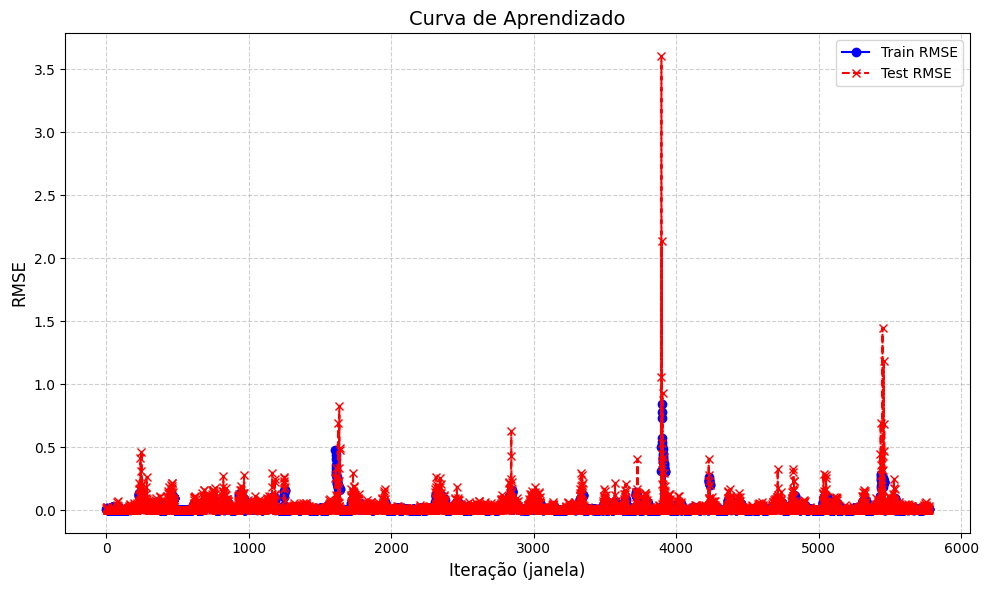

In [8]:
x_vals = range(len(resultado))  # ou resultado['Data'] se quiser por data

plt.figure(figsize=(10, 6))
plt.plot(x_vals, resultado['Train RMSE'], label='Train RMSE', marker='o', linestyle='-', color='blue')
plt.plot(x_vals, resultado['Test RMSE'], label='Test RMSE', marker='x', linestyle='--', color='red')
plt.title('Curva de Aprendizado', fontsize=14)
plt.xlabel('Iteração (janela)', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

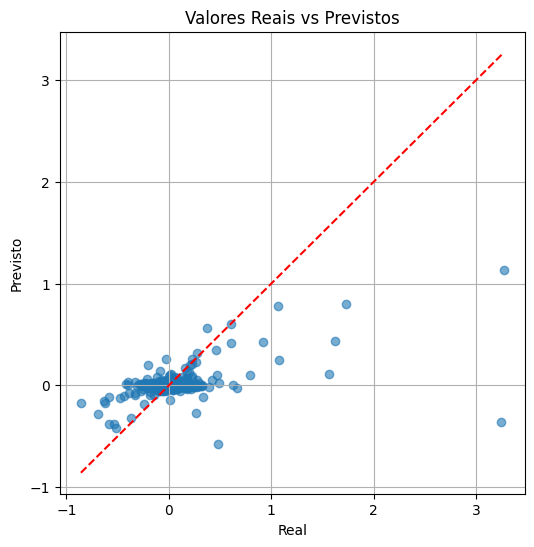

In [9]:
plt.figure(figsize=(6, 6))
plt.scatter(resultado['Real'], resultado['Previsto'], alpha=0.6)
plt.plot([resultado['Real'].min(), resultado['Real'].max()],
         [resultado['Real'].min(), resultado['Real'].max()],
         color='red', linestyle='--')
plt.xlabel('Real')
plt.ylabel('Previsto')
plt.title('Valores Reais vs Previstos')
plt.grid(True)
plt.show()

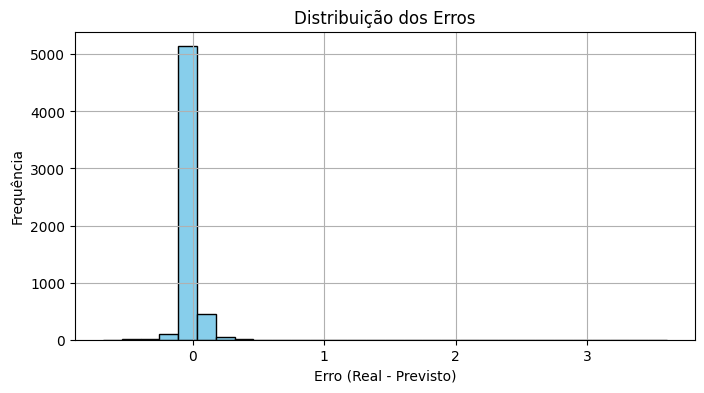

In [10]:
resultado['Erro'] = resultado['Real'] - resultado['Previsto']

plt.figure(figsize=(8, 4))
plt.hist(resultado['Erro'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuição dos Erros')
plt.xlabel('Erro (Real - Previsto)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

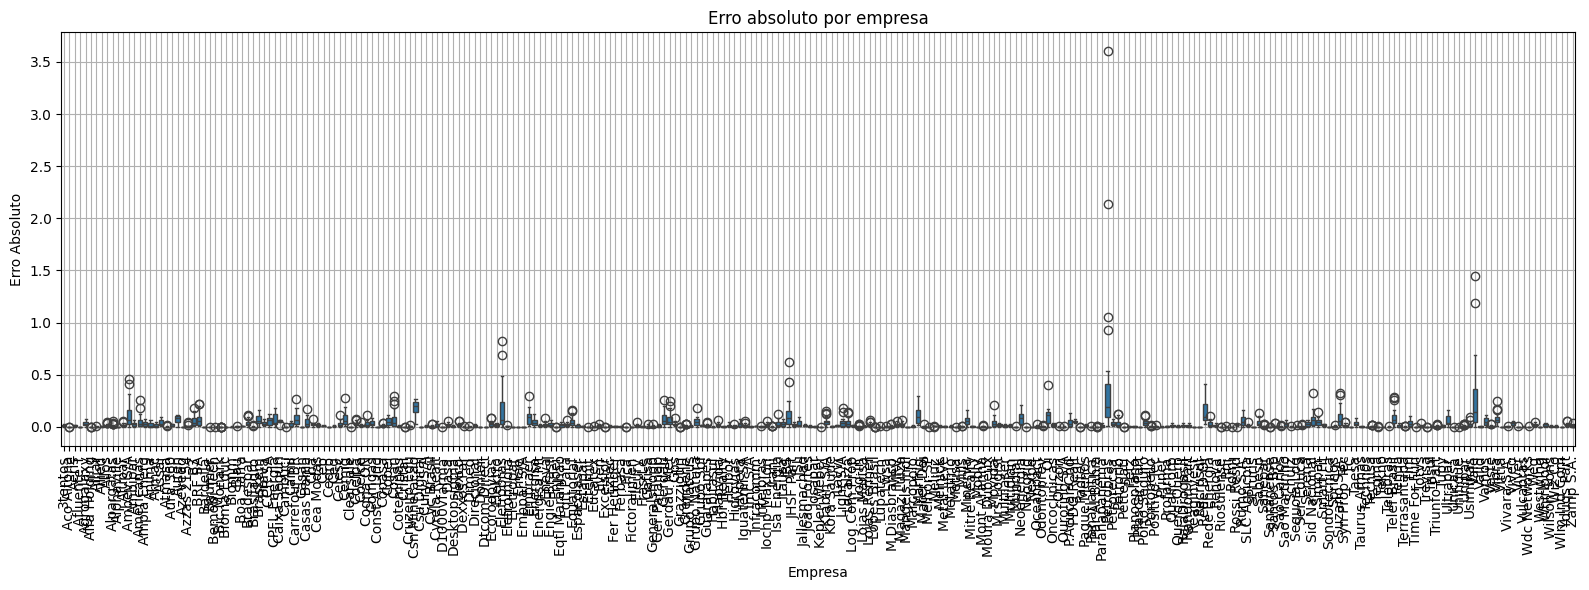

In [11]:
plt.figure(figsize=(16,6))
sns.boxplot(data=resultado, x='Empresa', y='Erro Absoluto')
plt.xticks(rotation=90)
plt.title('Erro absoluto por empresa')
plt.grid(True)
plt.tight_layout()
plt.show()

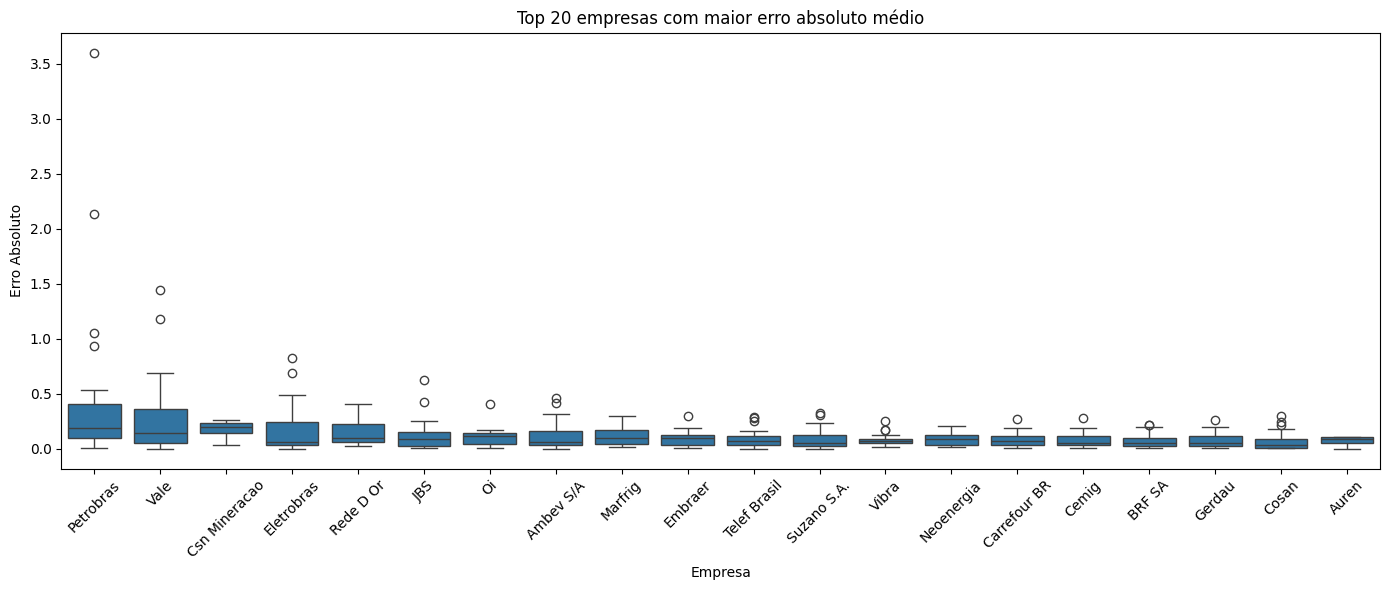

In [12]:
top_n = 20
top_empresas = resultado.groupby('Empresa')['Erro Absoluto'].mean().nlargest(top_n).index

plt.figure(figsize=(14, 6))
sns.boxplot(data=resultado[resultado['Empresa'].isin(top_empresas)],
            x='Empresa', y='Erro Absoluto', order=top_empresas)
plt.xticks(rotation=45)
plt.title(f'Top {top_n} empresas com maior erro absoluto médio')
plt.tight_layout()
plt.show()


Importância média das features:
         Feature  Importance
0  g_FCLF_scaled    0.018030
6             DE    0.002435
1         EBITDA    0.002036
2            ROE    0.001818
7     lag_g_fclf    0.001637
5            GMV    0.000998
3             LG    0.000832
8      ma_g_fclf    0.000806
4            ROA    0.000672


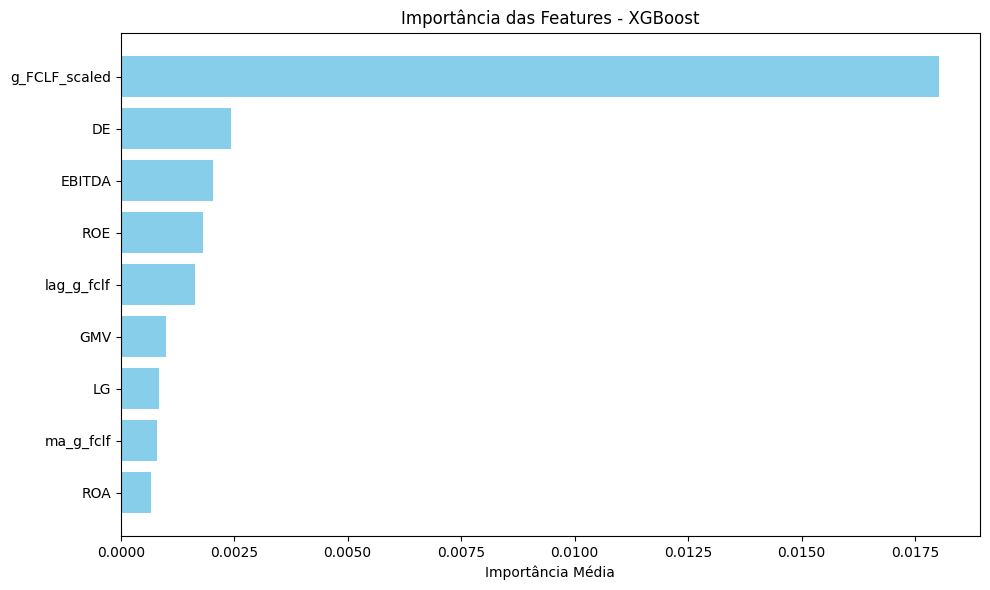

In [13]:
# Importância das features
print("\nImportância média das features:")
print(importancias)

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(importancias['Feature'], importancias['Importance'], color='skyblue')
plt.xlabel('Importância Média')
plt.title('Importância das Features - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

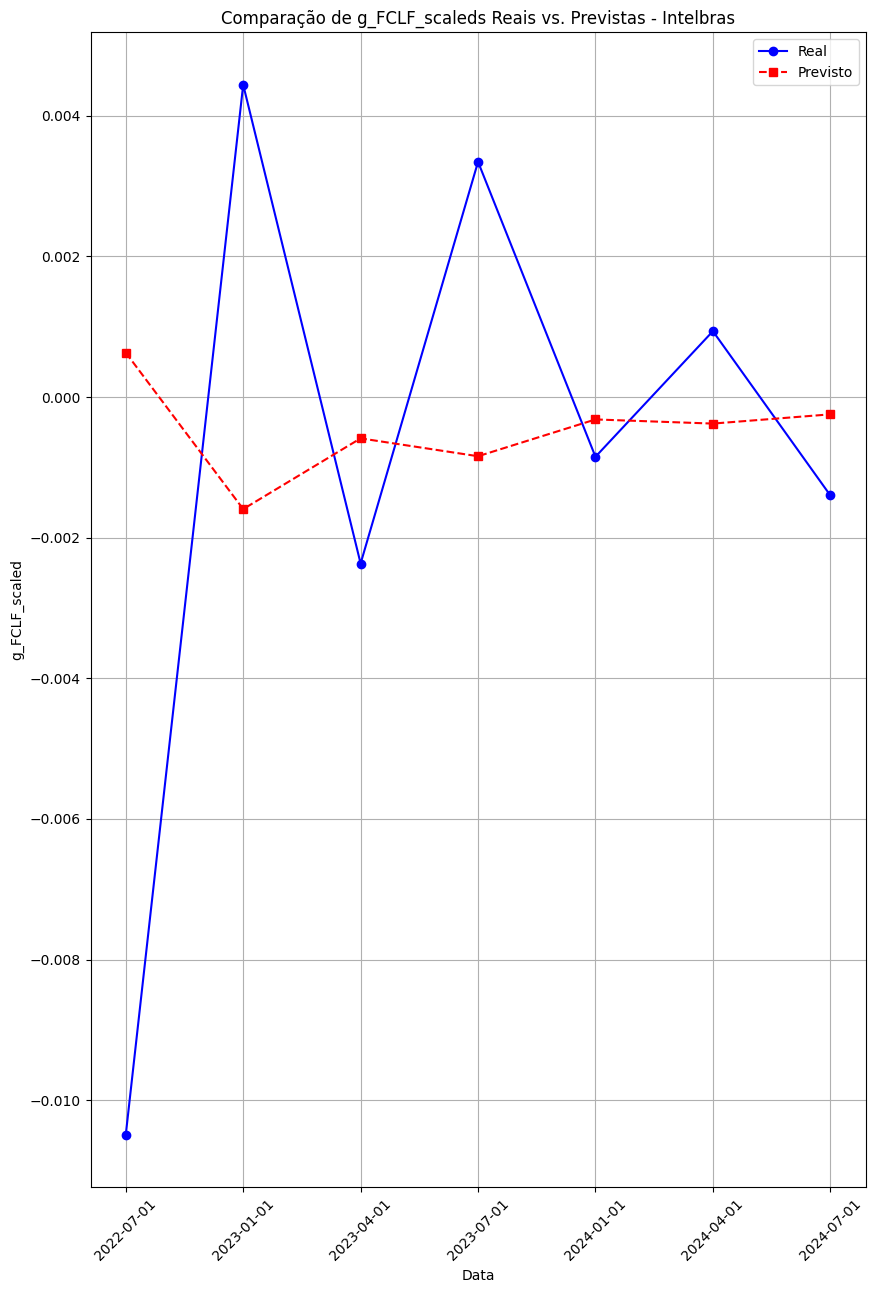

In [14]:
results_df = resultado
empresa_selecionada = 'Intelbras'
df_selecionado = results_df[results_df["Empresa"] == empresa_selecionada]

plt.figure(figsize=(10,15))
plt.plot(df_selecionado["Data"], df_selecionado["Real"], label="Real", marker='o', linestyle='solid', color="blue")
plt.plot(df_selecionado["Data"], df_selecionado["Previsto"], label="Previsto", marker='s', linestyle='dashed', color="red")

plt.xlabel("Data")
plt.ylabel("g_FCLF_scaled")
plt.title(f"Comparação de g_FCLF_scaleds Reais vs. Previstas - {empresa_selecionada}")
plt.legend()
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo X para melhor visualização
plt.grid(True)

plt.show()